In [1]:
# Guide: https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-auto-train-yolov8-model-with-autodistill.ipynb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install autodistill autodistill-grounded-sam autodistill-yolov8 roboflow supervision fastapi kaleido python-multipart uvicorn



In [4]:
# display image count

import supervision as sv

IMAGE_DIR_PATH = f"/content/drive/MyDrive/Inventory boxes/Inventory boxes train"

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpeg"])

print('image count:', len(image_paths))

image count: 28


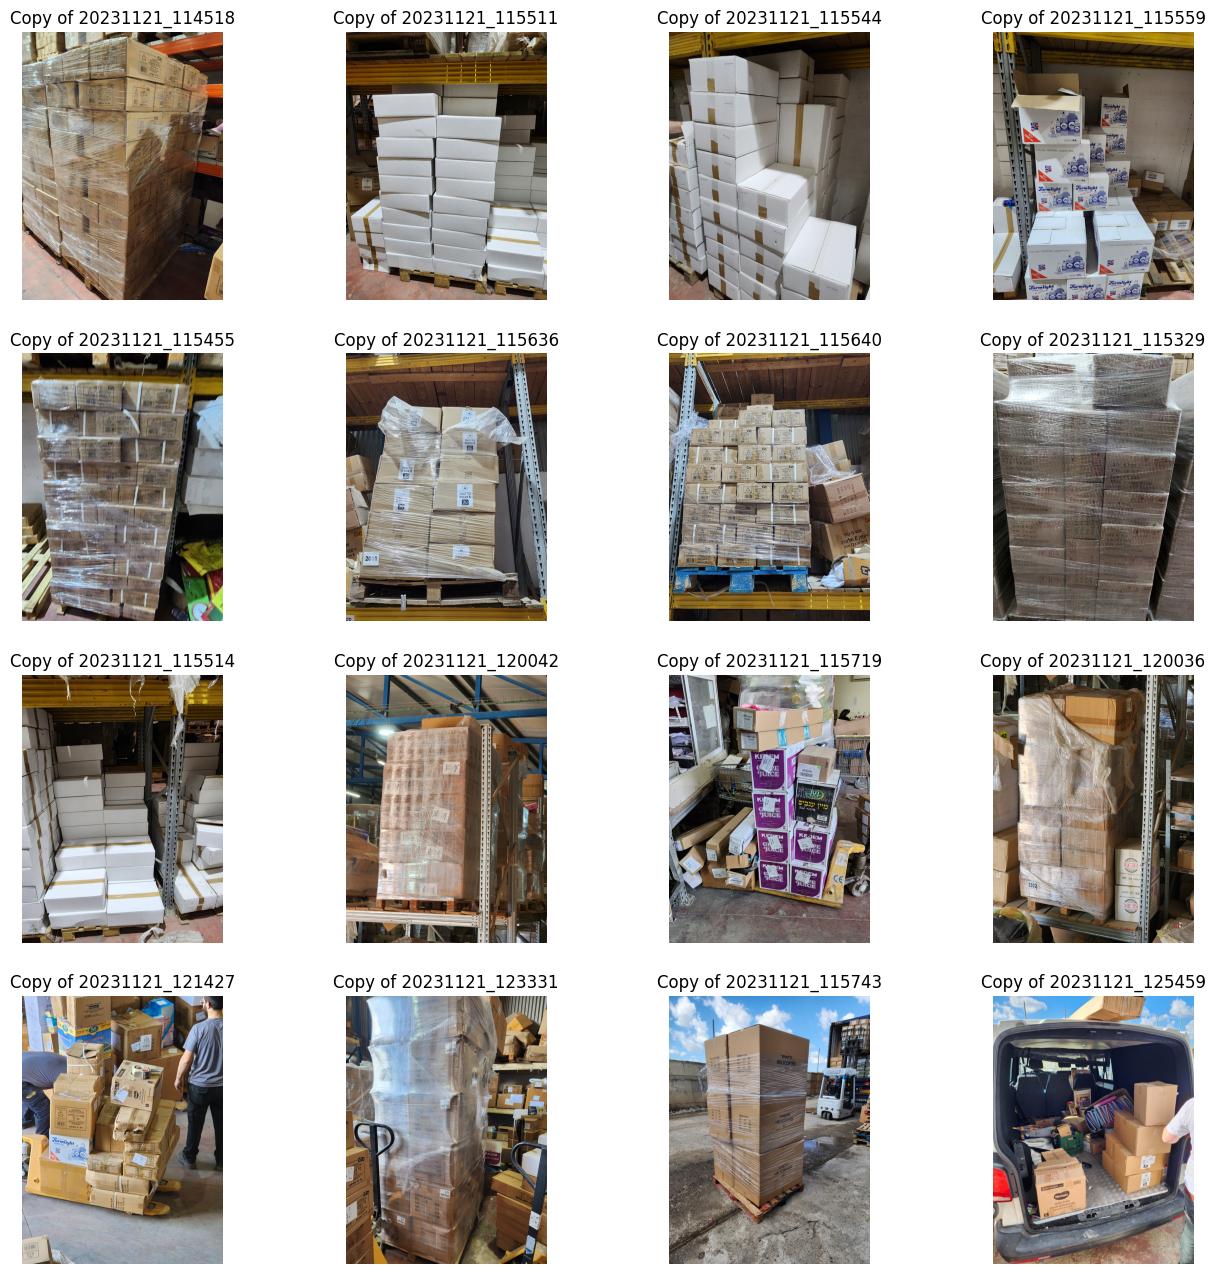

In [5]:
# create and display image sample

SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)


import cv2

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

In [6]:
# Autolabel dataset (Ontology definition, basemodel initiation )

# Define ontology
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
        "box": "box"
})

In [7]:
# Initiate base model and autolabel

DATASET_DIR_PATH = f"/content/drive/MyDrive/Inventory boxes/Dataset"

# We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
downloading dino model weights


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Labeling /content/drive/MyDrive/Inventory boxes/Inventory boxes train/Copy of 20231121_114518.jpg:   0%|          | 0/23 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Labeling /content/drive/MyDrive/Inventory boxes/Inventory boxes train/Copy of 20231121_115511.jpg:   4%|▍         | 1/23 [00:16<06:07, 16.71s/it]The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be upd

Labeled dataset created - ready for distillation.


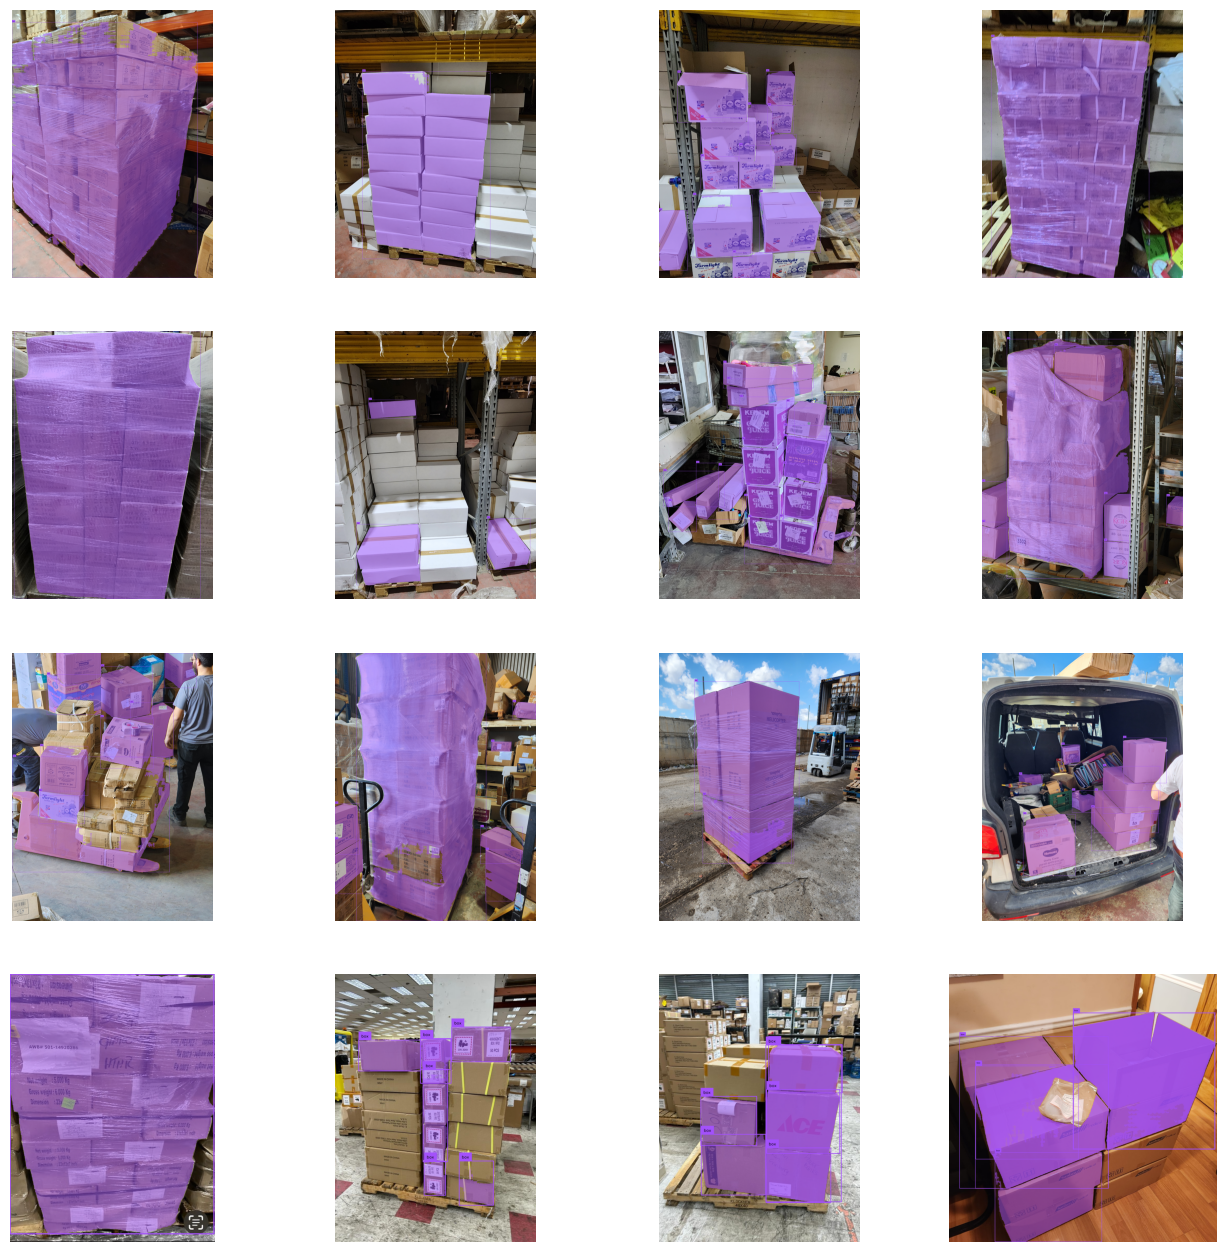

In [8]:
# Display dataset sample

ANNOTATIONS_DIRECTORY_PATH = f"/content/drive/MyDrive/Inventory boxes/Dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"/content/drive/MyDrive/Inventory boxes/Dataset/train/images"
DATA_YAML_PATH = f"/content/drive/MyDrive/Inventory boxes/Dataset/data.yaml"



dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)



image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    #titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

In [9]:
# Train target model - YOLOv8


from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=100)

100%|██████████| 6.23M/6.23M [00:00<00:00, 76.7MB/s]
New https://pypi.org/project/ultralytics/8.0.222 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Inventory boxes/Dataset/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=Fal

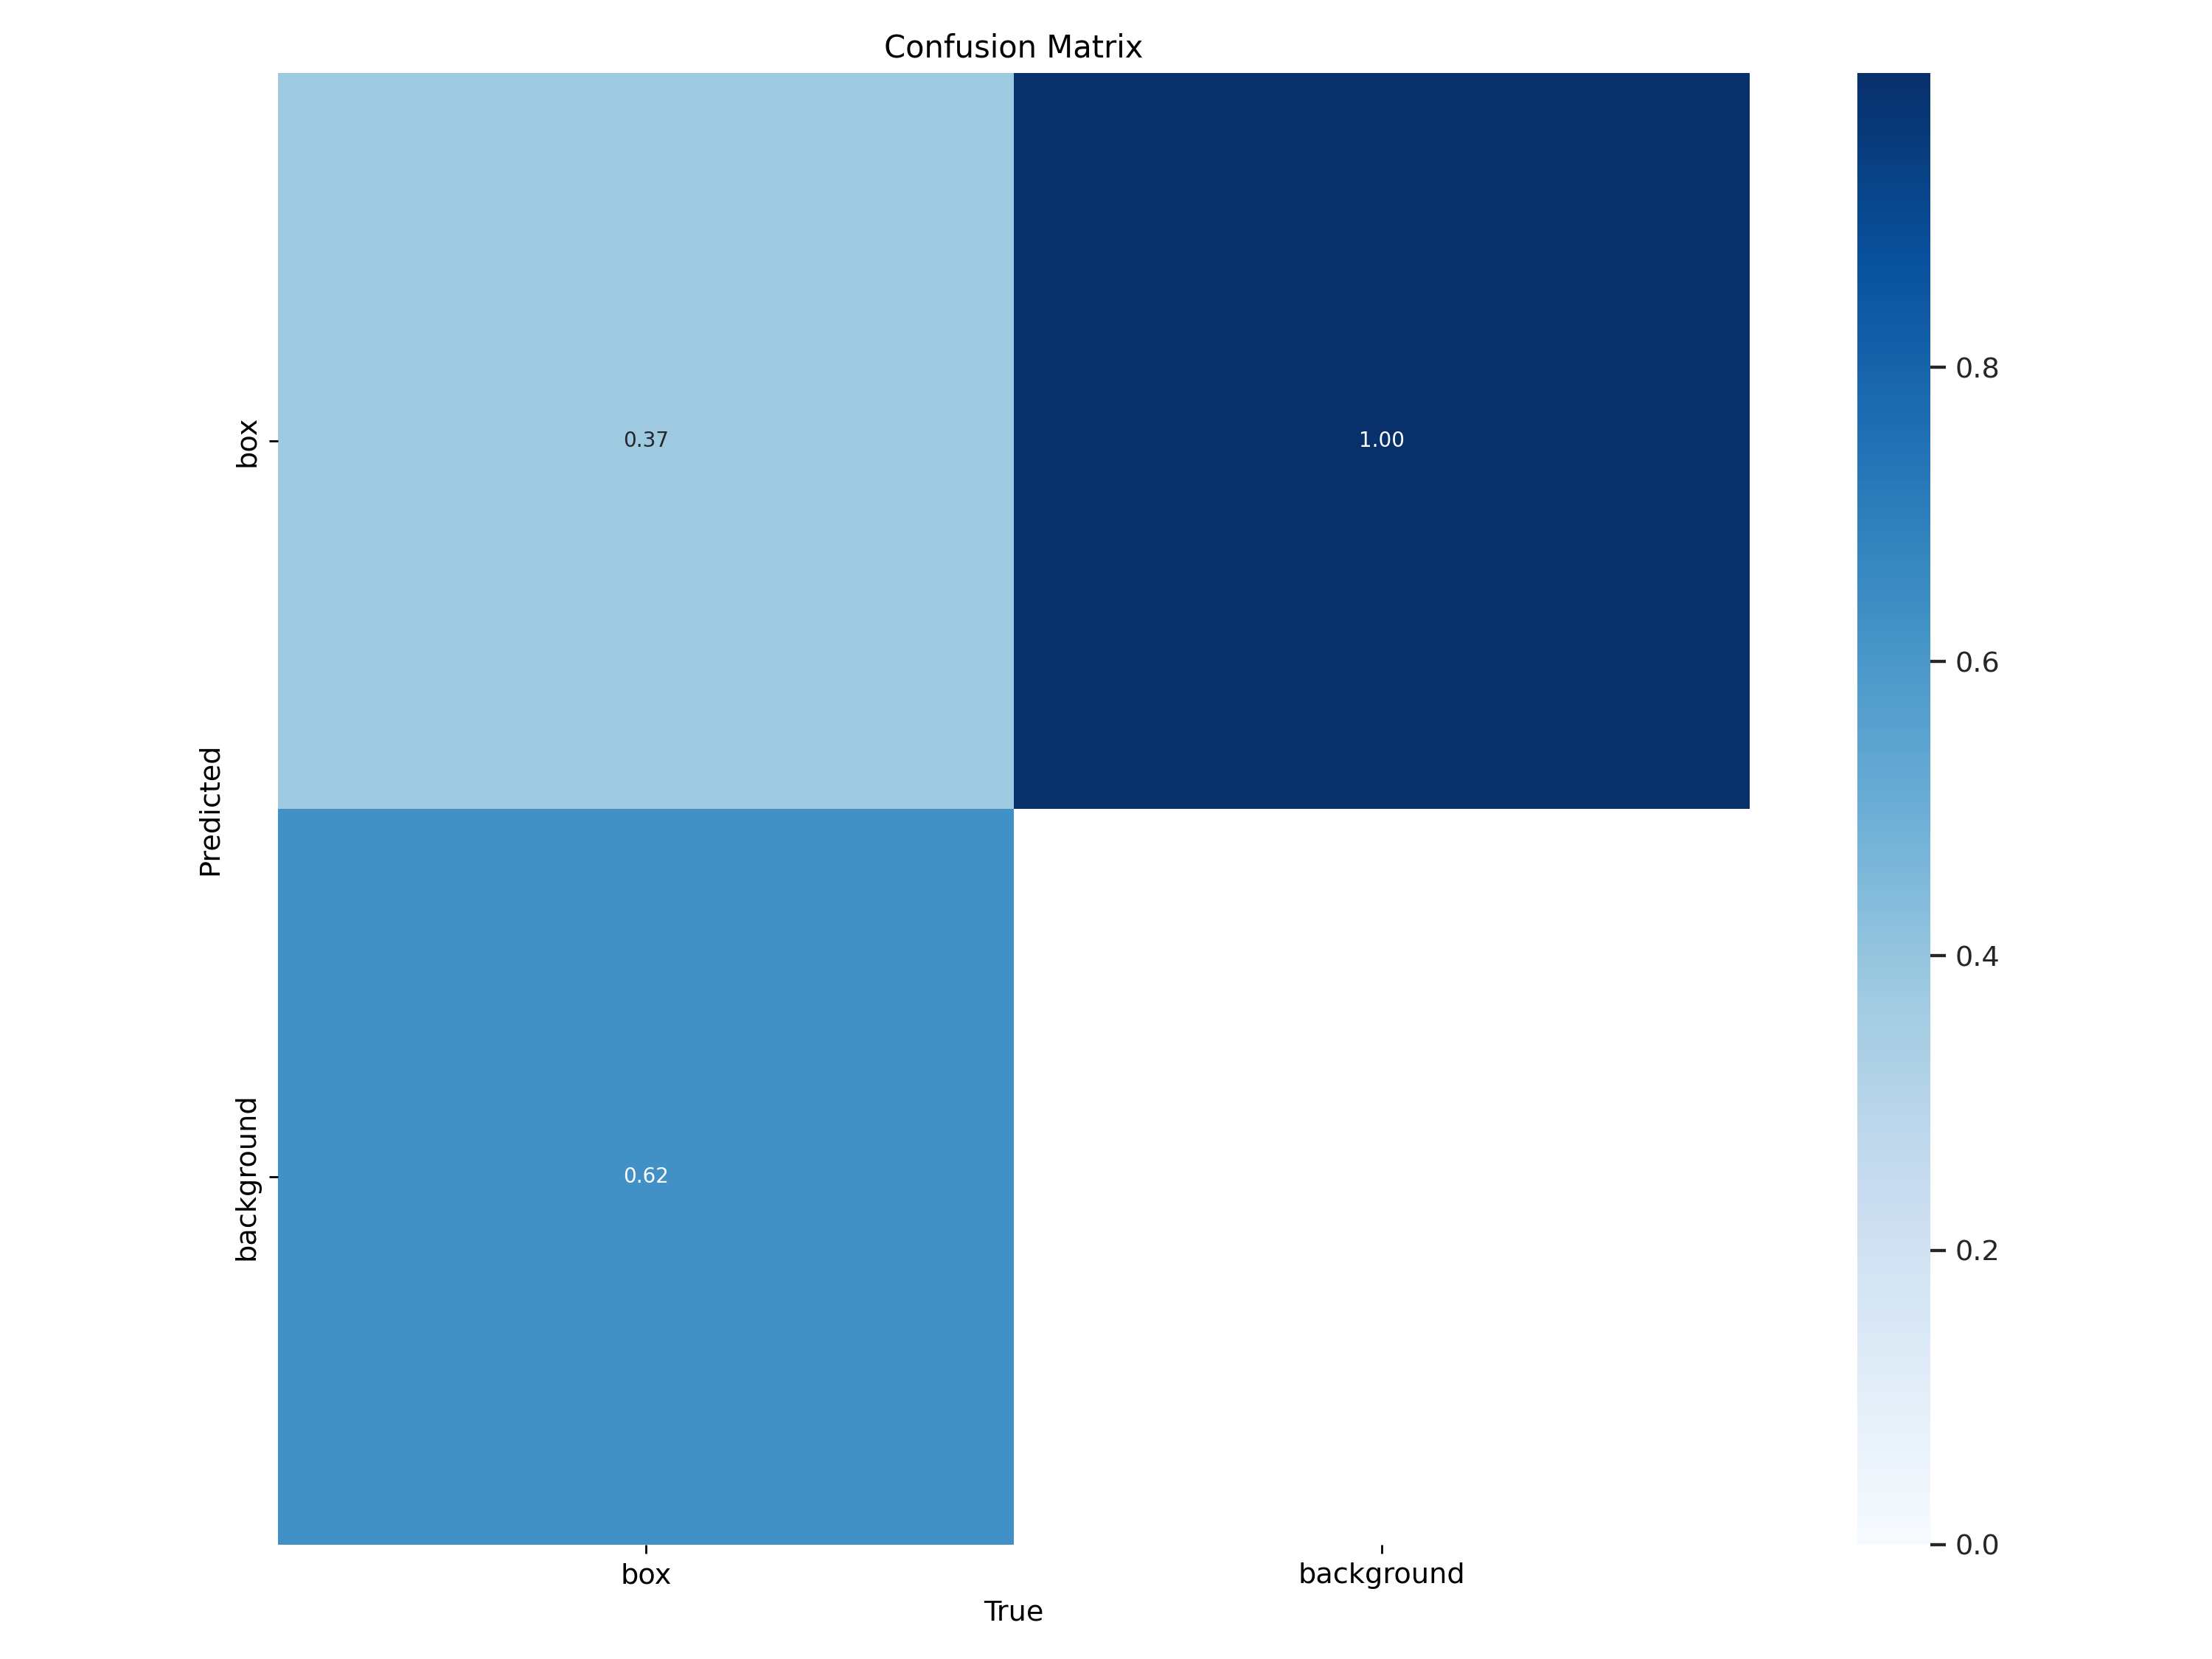

In [16]:
# Evaluate target model

from IPython.display import Image

Image(filename=f'/content/runs/detect/train/confusion_matrix.png', width=800)

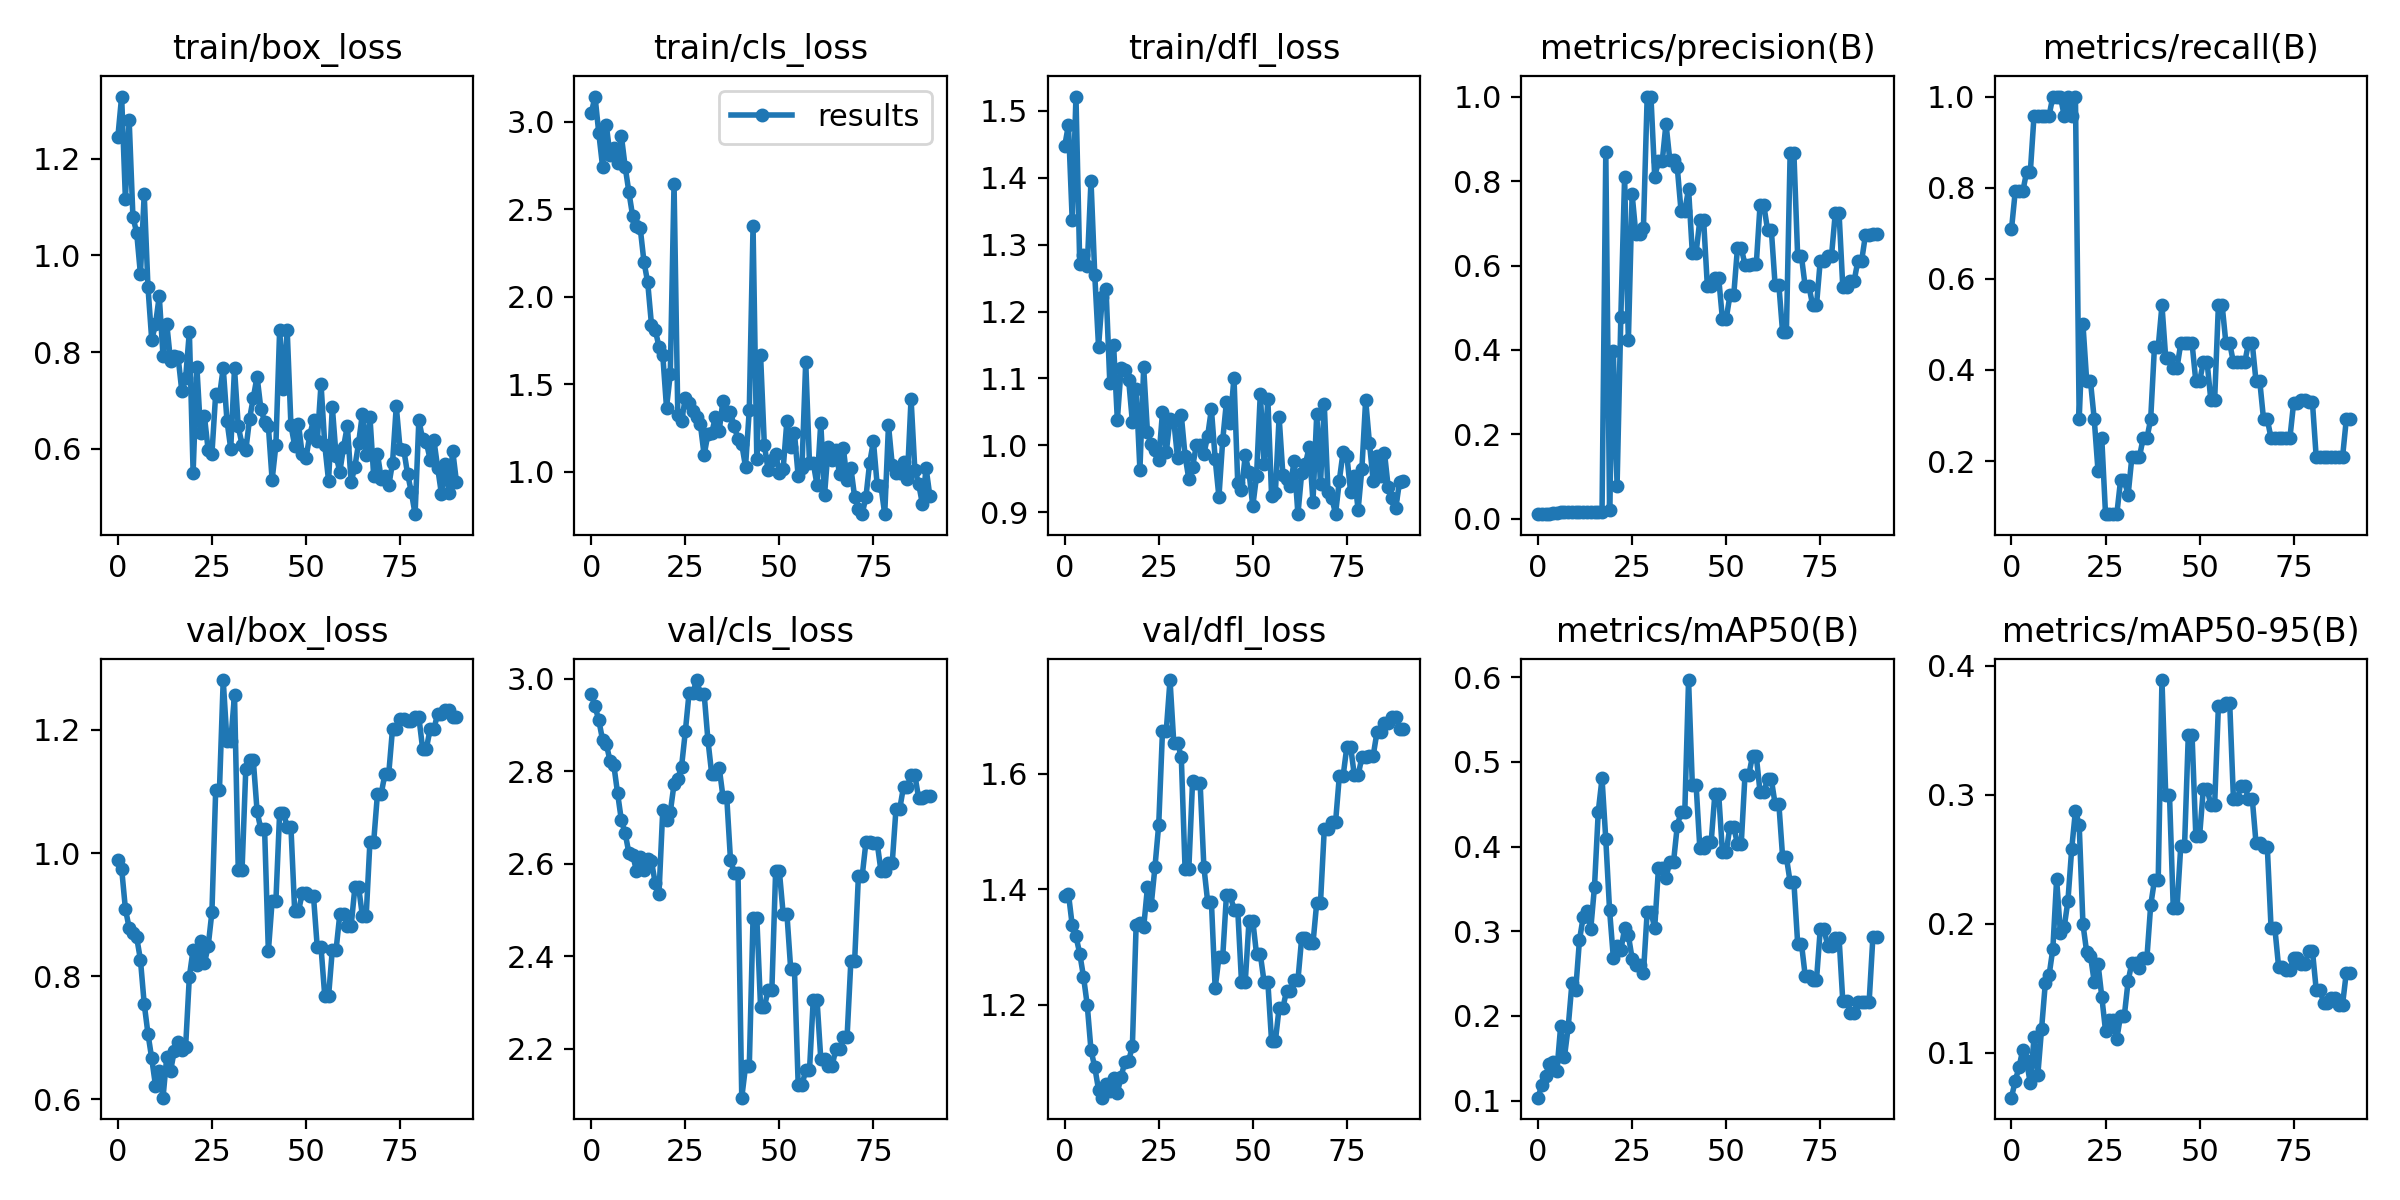

In [17]:
Image(filename=f'/content/runs/detect/train/results.png', width=800)

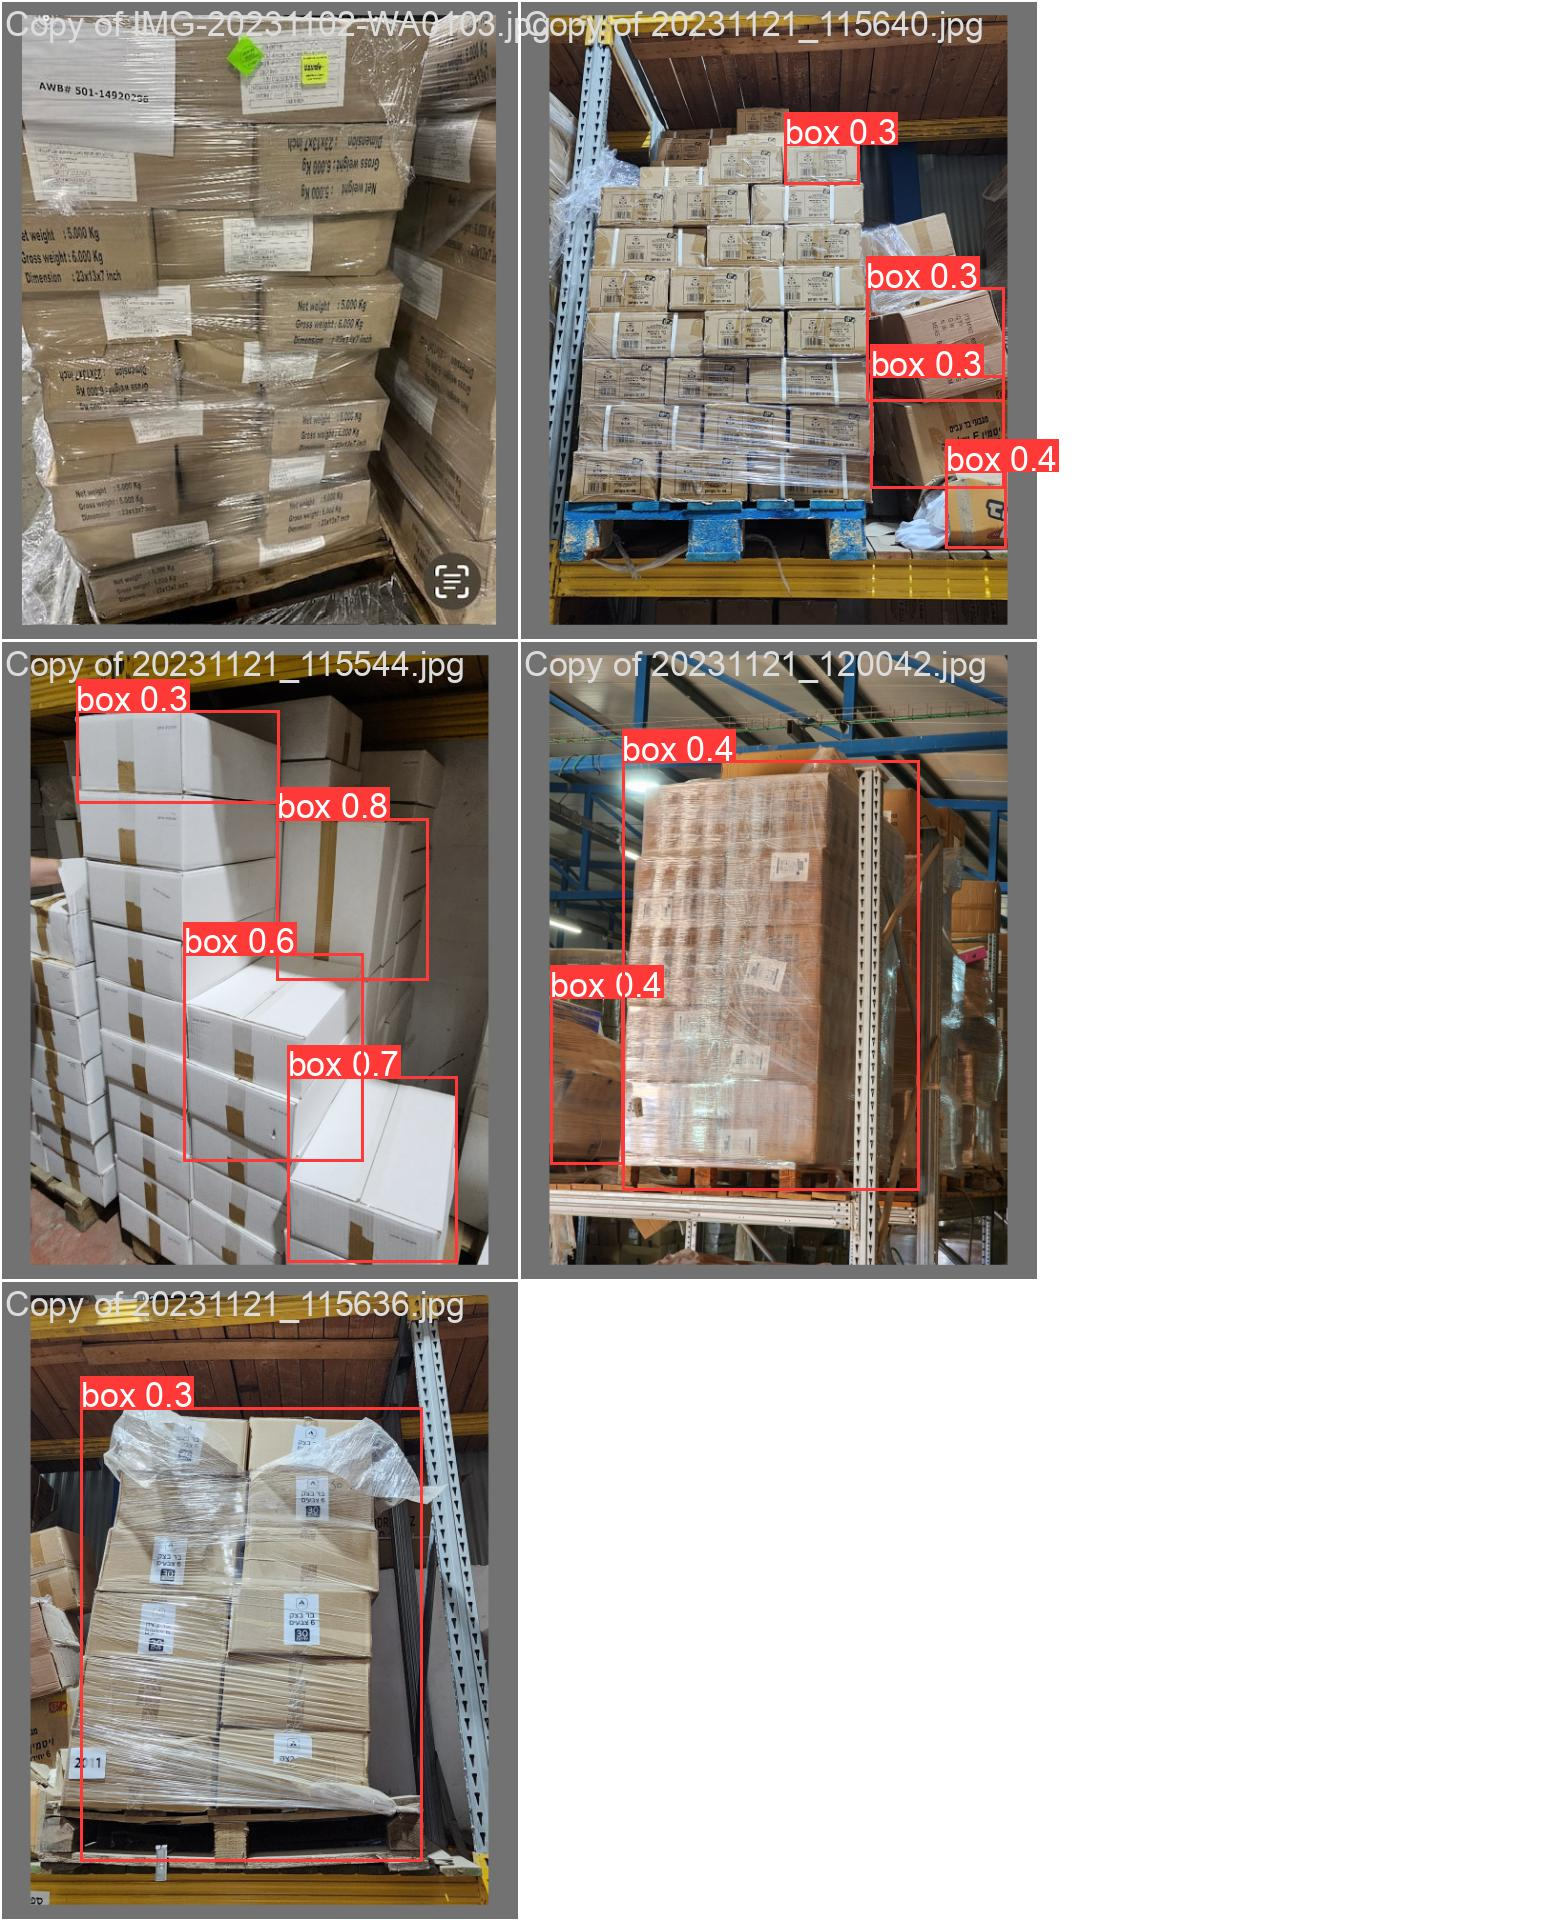

In [18]:
Image(filename=f'/content/runs/detect/train/val_batch0_pred.jpg', width=800)